In [1]:
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
import tensorflow as tf; 
print(tf.version)

<module 'tensorflow_core._api.v2.version' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\tensorflow_core\\_api\\v2\\version\\__init__.py'>


In [14]:
input_width = 28
input_height = 28
output_classes = 11

In [9]:
%matplotlib inline

def read_image(filePath):
    image = Image.open(filePath)

    # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.resize
    image = image.resize((input_width, input_height), Image.LANCZOS)

    # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.convert
    image = image.convert("L")

    image = np.asarray(image)

    return np.asarray(image).astype(np.float32) / 255.

def read_images(path):
    files = os.listdir(path)    
    files = [file for file in files if file[-4:] == ".png"]
    random.shuffle(files)
    images = []
    for file in files:
        try:
            images.append(read_image(os.path.join(path, file)))
        except OSError:
            pass
    
    return images

test_samples_per_digit = 10
x_train_arr = []
y_train_arr = []
x_test_arr = []
y_test_arr = []
for i in range(output_classes):
    images = read_images("images/labeled/" + str(i))
    print("Digit: " + str(i) + "; Images: " + str(len(images)))
    #plt.imshow(images[0])
    #plt.show()
    idx = 0
    for image in images:
        if idx < test_samples_per_digit:
            x_test_arr.append(image)
            y_test_arr.append(i)  
        else:
            x_train_arr.append(image)
            y_train_arr.append(i)
        idx = idx + 1
    
# convert to numpy types
x_train = np.asarray(x_train_arr)#.astype(np.float32) / 255.
y_train = to_categorical(y_train_arr)
x_test = []
y_test = []
if test_samples_per_digit > 0:
    x_test = np.asarray(x_test_arr)#.astype(np.float32) / 255.
    y_test = to_categorical(y_test_arr)
#print("x_train: " + str(x_train))
#print("y_train: " + str(y_train))
#print("##########################")
#print("x_test: " + str(x_test))
#print("y_test: " + str(y_test))

Digit: 0; Images: 645
Digit: 1; Images: 622
Digit: 2; Images: 263
Digit: 3; Images: 777
Digit: 4; Images: 112
Digit: 5; Images: 173
Digit: 6; Images: 250
Digit: 7; Images: 267
Digit: 8; Images: 368
Digit: 9; Images: 234
Digit: 10; Images: 281


In [10]:
def createModel():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation = 'relu', input_shape = (input_height, input_width, 1)))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.5))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.5))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_classes, activation = 'softmax'))

    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])
    return model

In [11]:
model = createModel()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 32)         

In [12]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(width_shift_range=3, height_shift_range=3, zoom_range=0.1, horizontal_flip=False)

if False:
    model.fit(
        x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1),
        y_train,
        epochs=2000,
        batch_size=256)
else:
    model.fit_generator(gen.flow(
        x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1), 
        y_train, batch_size=128, shuffle=True), epochs=50, workers=8, steps_per_epoch=256)

  ...
    to  
  ['...']
Train for 256 steps
Epoch 1/50
256/256 [==============================] - 22s 85ms/step - loss: 1.3703 - acc: 0.5637
Epoch 2/50
256/256 [==============================] - 20s 77ms/step - loss: 0.6390 - acc: 0.8057
Epoch 3/50
256/256 [==============================] - 21s 82ms/step - loss: 0.4759 - acc: 0.8490
Epoch 4/50
256/256 [==============================] - 22s 85ms/step - loss: 0.3991 - acc: 0.8750
Epoch 5/50
256/256 [==============================] - 21s 81ms/step - loss: 0.3560 - acc: 0.8887
Epoch 6/50
256/256 [==============================] - 20s 77ms/step - loss: 0.3171 - acc: 0.9016
Epoch 7/50
256/256 [==============================] - 20s 79ms/step - loss: 0.2862 - acc: 0.9106
Epoch 8/50
256/256 [==============================] - 21s 83ms/step - loss: 0.2629 - acc: 0.9190
Epoch 9/50
256/256 [==============================] - 21s 80ms/step - loss: 0.2397 - acc: 0.9252
Epoch 10/50
256/256 [==============================] - 20s 77ms/step - loss: 0.228

correct: True; expcted: 0; predicted: 0; confidence: 1.0
correct: True; expcted: 0; predicted: 0; confidence: 1.0
correct: True; expcted: 0; predicted: 0; confidence: 1.0
correct: True; expcted: 0; predicted: 0; confidence: 1.0
correct: True; expcted: 0; predicted: 0; confidence: 1.0
correct: True; expcted: 0; predicted: 0; confidence: 1.0
correct: True; expcted: 0; predicted: 0; confidence: 1.0
correct: True; expcted: 0; predicted: 0; confidence: 1.0
correct: True; expcted: 0; predicted: 0; confidence: 1.0
correct: True; expcted: 0; predicted: 0; confidence: 1.0
correct: True; expcted: 1; predicted: 1; confidence: 1.0
correct: True; expcted: 1; predicted: 1; confidence: 1.0
correct: True; expcted: 1; predicted: 1; confidence: 1.0
correct: True; expcted: 1; predicted: 1; confidence: 1.0
correct: True; expcted: 1; predicted: 1; confidence: 1.0
correct: True; expcted: 1; predicted: 1; confidence: 1.0
correct: True; expcted: 1; predicted: 1; confidence: 1.0
correct: True; expcted: 1; pred

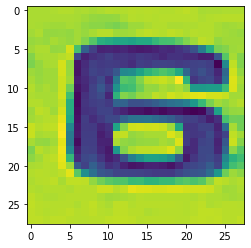

correct: True; expcted: 6; predicted: 6; confidence: 1.0
correct: True; expcted: 7; predicted: 7; confidence: 1.0
correct: True; expcted: 7; predicted: 7; confidence: 1.0
correct: True; expcted: 7; predicted: 7; confidence: 1.0
correct: True; expcted: 7; predicted: 7; confidence: 1.0
correct: True; expcted: 7; predicted: 7; confidence: 1.0
correct: True; expcted: 7; predicted: 7; confidence: 1.0
correct: True; expcted: 7; predicted: 7; confidence: 1.0
correct: True; expcted: 7; predicted: 7; confidence: 1.0
correct: True; expcted: 7; predicted: 7; confidence: 1.0
correct: True; expcted: 7; predicted: 7; confidence: 1.0
correct: True; expcted: 8; predicted: 8; confidence: 1.0
correct: True; expcted: 8; predicted: 8; confidence: 1.0
correct: True; expcted: 8; predicted: 8; confidence: 1.0
correct: True; expcted: 8; predicted: 8; confidence: 1.0
correct: True; expcted: 8; predicted: 8; confidence: 1.0
correct: True; expcted: 8; predicted: 8; confidence: 0.61


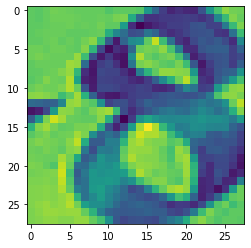

correct: True; expcted: 8; predicted: 8; confidence: 1.0
correct: True; expcted: 8; predicted: 8; confidence: 0.69


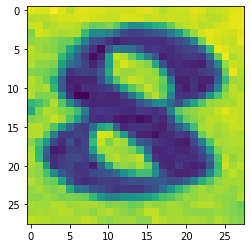

correct: True; expcted: 8; predicted: 8; confidence: 1.0
correct: True; expcted: 8; predicted: 8; confidence: 0.35


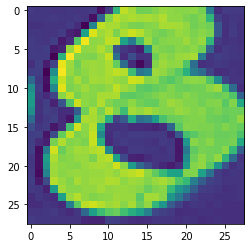

correct: True; expcted: 9; predicted: 9; confidence: 1.0
correct: True; expcted: 9; predicted: 9; confidence: 1.0
correct: True; expcted: 9; predicted: 9; confidence: 0.88
correct: True; expcted: 9; predicted: 9; confidence: 1.0
correct: True; expcted: 9; predicted: 9; confidence: 1.0
correct: True; expcted: 9; predicted: 9; confidence: 1.0
correct: True; expcted: 9; predicted: 9; confidence: 0.99
correct: True; expcted: 9; predicted: 9; confidence: 1.0
correct: True; expcted: 9; predicted: 9; confidence: 1.0
correct: True; expcted: 9; predicted: 9; confidence: 1.0
correct: True; expcted: 10; predicted: 10; confidence: 1.0
correct: True; expcted: 10; predicted: 10; confidence: 0.94
correct: True; expcted: 10; predicted: 10; confidence: 1.0
correct: True; expcted: 10; predicted: 10; confidence: 1.0
correct: True; expcted: 10; predicted: 10; confidence: 1.0
correct: True; expcted: 10; predicted: 10; confidence: 0.96
correct: True; expcted: 10; predicted: 10; confidence: 1.0
correct: True

In [13]:
def predict(img):
    result = model.predict(img.reshape(1, img.shape[0], img.shape[1], 1))
    pred = np.argmax(result, axis = 1)[0]
    convidence = result[0][pred]
    return (pred, convidence)

def predict_test(idx):
    result = predict(x_test[idx])
    pred = result[0]
    convidence = result[1]
    expect = y_test_arr[idx]
    correct = expect == pred    
    print("correct: " + str(correct) + 
          "; expcted: " + str(expect) + 
          "; predicted: " + str(pred) + 
          "; confidence: " + str(round(convidence, 2)))
    if not correct or convidence < 0.7:
        plt.imshow(x_test[idx])
        plt.show()
for i in range(len(x_test_arr)):
    predict_test(i)

In [15]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
filename = "ocr_model_" + str(input_width) + "x" + str(input_height) + "_c" + str(output_classes)
print("writing " + filename + ".tflite")
open(filename + ".tflite", "wb").write(tflite_model)
print("Now you have to call the following in git bash: xxd -i " + filename + ".tflite > " + filename + ".c")

writing ocr_model_28x28_c11.tflite
Now you have to call the following in git bash: xxd -i ocr_model_28x28_c11.tflite > ocr_model_28x28_c11.c
